In [1]:
from spreg import OLS, vif, OLS_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily
import fiona; help(fiona.open)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Help on function open in module fiona:

open(fp, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None, **kwargs)
    Open a collection for read, append, or write
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings like
    
      {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'W

In [2]:
env = gpd.read_file('../raw_data/more_maps/environment_2022.shp')


In [3]:
env

,plr,plr_name,kategorie,bioklima,gruenfl,laerm,luft,geometry
0,01100101,Stülerstraße,zweifach,mittel,schlecht,mittel,hoch,"POLYGON ((387952.642 5818274.558, 387924.234 5..."
1,01100102,Großer Tiergarten,keine starke Belastung,mittel,gut,mittel,mittel,"POLYGON ((389869.327 5820074.331, 389869.304 5..."
2,01100103,Lützowstraße,dreifach,hoch,schlecht,gering,hoch,"POLYGON ((387952.642 5818274.558, 387986.686 5..."
3,01100104,Körnerstraße,zweifach,hoch,gut,mittel,hoch,"POLYGON ((389319.585 5817775.805, 389310.128 5..."
4,01100205,Wilhelmstraße,dreifach,hoch,gut,hoch,hoch,"POLYGON ((389835.709 5819672.186, 389851.284 5..."
...,...,...,...,...,...,...,...,...
537,12601032,Rollbergesiedlung,keine starke Belastung,mittel,gut,gering,mittel,"POLYGON ((386416.954 5829708.452, 386392.827 5..."
538,12601133,Treuenbrietzener Straße,keine starke Belastung,mittel,mittel,mittel,mittel,"POLYGON ((389990.688 5829740.615, 389981.590 5..."
539,12601134,Märkisches Zentrum,keine starke Belastung,mittel,mittel,gering,mittel,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
540,12601235,Dannenwalder Weg,einfach,mittel,schlecht,mittel,mittel,"POLYGON ((389475.323 5828740.790, 389470.683 5..."


In [192]:
oeffi = gpd.read_file('../raw_data/maps/stations.shp')


In [193]:
oeffi

,Bahn_Typ_k,Bahn_Typ,geometry
0,S_R,"S-, Regionalbahn",POINT (405681.637 5818896.470)
1,S,S-Bahn,POINT (403304.504 5819005.608)
2,S,S-Bahn,POINT (408219.291 5819249.663)
3,S,S-Bahn,POINT (410018.541 5819495.176)
4,S,S-Bahn,POINT (411833.945 5819740.138)
...,...,...,...
1039,R,Regionalbahn,POINT (393302.162 5788522.695)
1040,R,Regionalbahn,POINT (393335.208 5786602.202)
1041,R,Regionalbahn,POINT (395187.861 5780652.251)
1042,R,Regionalbahn,POINT (395952.129 5777589.272)


<AxesSubplot:>

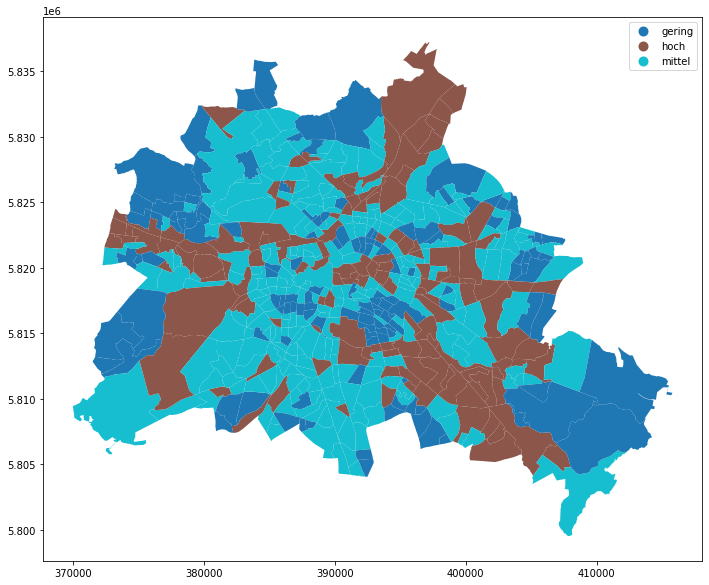

In [4]:
env.plot('laerm', figsize=(15,10),legend=True) 

In [15]:
# Load regression gds 

selected = gpd.read_file('../YouthInTheCity/data/regression_gdf.shp')

# Select features manually
selected.drop(columns=['schools', 'universiti', 'kindergart','HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
              'schools', 'universiti','kindergart','night_life',
                       'mig_rate','HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'BZR_NAME', 
              'noise',  'health_car', 'vegpm10', 'change','ch_rate',
            'public_tra', 'green' ,'other_sch', 'secon_sch','vocat_sch',
                'sp_nee_sch', 'community','night_life', 'water',  
              'public_ser','dyn_ew', 'dyn_unempl', 'priv_schoo', 'primary_sc',
                       'education', 'five_y_pls', 'dyn_sales','air', 'kita','eating','bio'], inplace=True)

# Export it as shapefile
selected.to_file('../raw_data/basic_model_gdf.shp', mode="w")

# Load it again
selected = gpd.read_file('../raw_data/basic_model_gdf.shp')

In [16]:
# loading dbf
db = libpysal.io.open('../raw_data/basic_model_gdf.dbf','r')

# computing spatial weights
queen = libpysal.weights.Queen.from_dataframe(selected)
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)
rook = libpysal.weights.Rook.from_dataframe(selected)

In [17]:
selected.columns

Index(['PLR_ID', 'culture', 'outdoor_fa', 'outdoor_le', 'ave_rent',
       'social_hou', 'public_hou', 'child_pov', 'vegpm20', 'Gymnasium',
       'stations', 'geometry'],
      dtype='object')

In [18]:
corr = selected.corr()
corr_df = corr.unstack().reset_index() #Unstack correlation matrix
corr_df.columns = ["feature_1", "feature_2", "correlation"] #Rename the columns
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]] #remove the self-corr
corr_df.head(20)

,feature_1,feature_2,correlation
15,culture,ave_rent,0.568511
45,ave_rent,culture,0.568511
23,outdoor_fa,culture,0.447399
13,culture,outdoor_fa,0.447399
112,stations,outdoor_fa,0.421796
32,outdoor_fa,stations,0.421796
66,public_hou,PLR_ID,0.397318
6,PLR_ID,public_hou,0.397318
62,social_hou,child_pov,0.377728
82,child_pov,social_hou,0.377728


In [25]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [28]:
selected.columns

Index(['PLR_ID', 'culture', 'outdoor_fa', 'outdoor_le', 'ave_rent',
       'social_hou', 'public_hou', 'child_pov', 'vegpm20', 'Gymnasium',
       'stations', 'geometry'],
      dtype='object')

In [29]:
columns = [
        'culture', 'outdoor_fa', 'outdoor_le', 'ave_rent',
        'social_hou', 'public_hou', 'vegpm20', 'Gymnasium',
        'stations'
]

In [30]:
m1 = OLS(y,
        X,
        w=inv_dist,
        name_y='child_pov',
        name_x=columns,
        name_w='dist',
        name_ds='basic_model',
        white_test=True,
        gwk=inv_dist,
        spat_diag=True,
        moran=True)

(array([  9.,  28.,  96., 120., 116., 116.,  35.,   6.,   5.,   5.]),
 array([-0.29746313,  5.66168802, 11.62083916, 17.57999031, 23.53914146,
        29.49829261, 35.45744376, 41.4165949 , 47.37574605, 53.3348972 ,
        59.29404835]),
 <BarContainer object of 10 artists>)

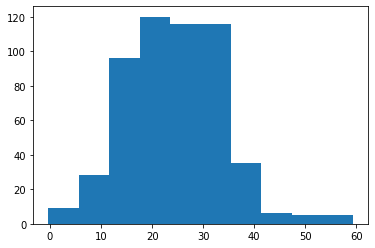

In [31]:
plt.hist(m1.predy.flatten())

<AxesSubplot:>

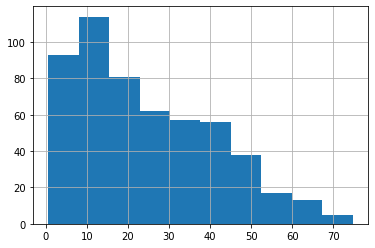

In [32]:
selected['child_pov'].hist()

In [33]:
mae(selected['child_pov'], m1.predy.flatten())

10.739417658657604

In [34]:
np.sqrt(mse(selected['child_pov'], m1.predy.flatten()))

13.740371077198775

In [35]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          10
S.D. dependent var  :     16.6701                Degrees of Freedom    :         526
R-squared           :      0.3193
Adjusted R-squared  :      0.3077
Sum squared residual:  101195.619                F-statistic           :     27.4200
Sigma-square        :     192.387                Prob(F-statistic)     :   5.687e-39
S.E. of regression  :      13.870                Log likelihood        :   -2165.052
Sigma-square ML     :     188.798                Akaike info criterion :    4350.105
S.E of regression ML:     13.7404                Schwarz criterion     :    4392.946

-----------------------------------------------------------------------------

In [36]:
# creating vif dataframe

v = vif(m1)
del(v[0])
vif_array = np.array(v, dtype=float)

v_d = pd.DataFrame({'feature': columns, 
                   'vif': vif_array[:,0], 
                   'tolerance':  vif_array[:,1]})

v_d

,feature,vif,tolerance
0,culture,1.921714,0.520369
1,outdoor_fa,1.559412,0.641268
2,outdoor_le,1.202147,0.831845
3,ave_rent,1.927413,0.518830
4,social_hou,1.252289,0.798537
5,public_hou,1.544300,0.647542
6,vegpm20,1.098164,0.910611
7,Gymnasium,1.122364,0.890977
8,stations,1.628312,0.614133


<AxesSubplot:>

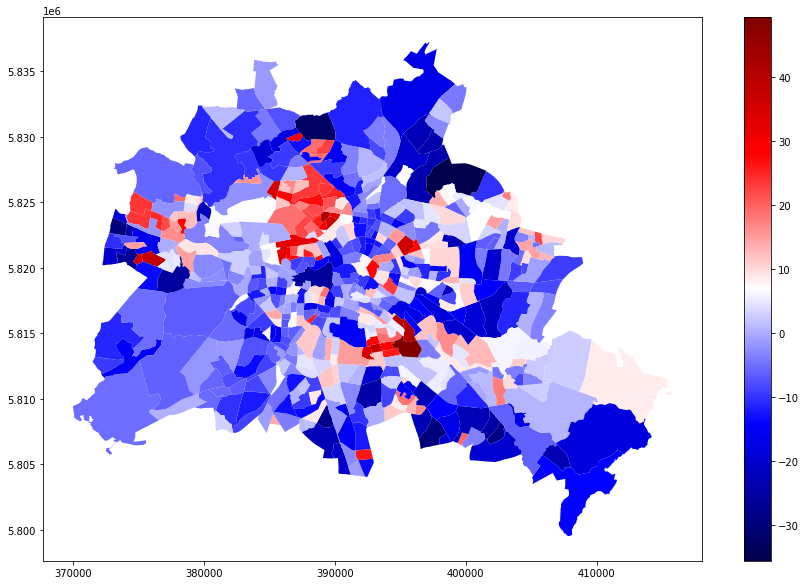

In [37]:
# Adding a resituals column to sample dataframe
selected['residuals'] = m1.u

# plotting residuals - red = underestimation, blue = overestimation
selected.plot('residuals', figsize=(15,10), cmap= 'seismic', legend=True)

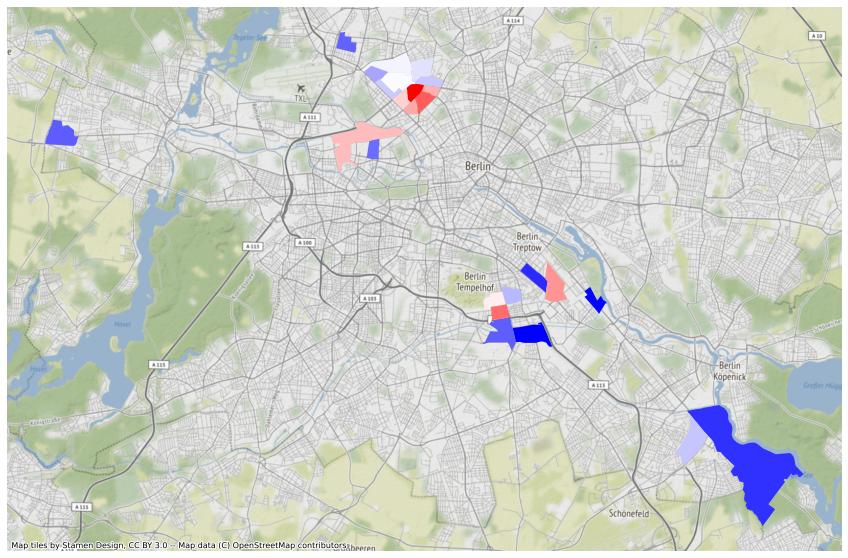

In [38]:
# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(selected, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    selected.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,10))
)
# Add basemap
contextily.add_basemap(ax, crs=selected.crs)
# Remove axes
ax.set_axis_off();

In [29]:
pr2021 = gpd.read_file('../raw_data/maps/pr_2021.shp')

pr2020 = gpd.read_file('../raw_data/maps/pr_2020.shp')

In [39]:
# loading east/west maps
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

# adapting projections
east.to_crs(crs='EPSG:25833', inplace=True)
west.to_crs(crs='EPSG:25833', inplace=True)

# dissolving
west = west.dissolve()
east = east.dissolve()

# merging both maps into an eastwest geodataframe
eastwest = east.append(west)

# adding an east column to eastwest geodataframe
eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

eastwest = eastwest[['east','geometry']]

# merging eastwest geodataframe with sample df

selected_east = selected.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

selected = selected.merge(selected_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

In [187]:
X.shape

(536, 11)

In [42]:
# Running an OLS Regimes model

m2 = OLS_Regimes(y,
                X,
                w=inv_dist,
                regimes=selected['east'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [43]:
print(m2.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         195
Mean dependent var  :     21.2256                Number of Variables   :          10
S.D. dependent var  :     15.2800                Degrees of Freedom    :         185
R-squared           :      0.3868
Adjusted R-squared  :      0.3570
Sum squared residual:   27774.090                F-statistic           :     12.9669
Sigma-square        :     150.130                Prob(F-statistic)     :   6.123e-16
S.E. of regression  :      12.253                Log likelihood        :    -760.182
Sigma-square ML     :     142.431                Akaike info criterion :    1540.364
S.E of regression ML:     11.9345                Schwarz criterion     :    1573.094

--------------------------------

<AxesSubplot:>

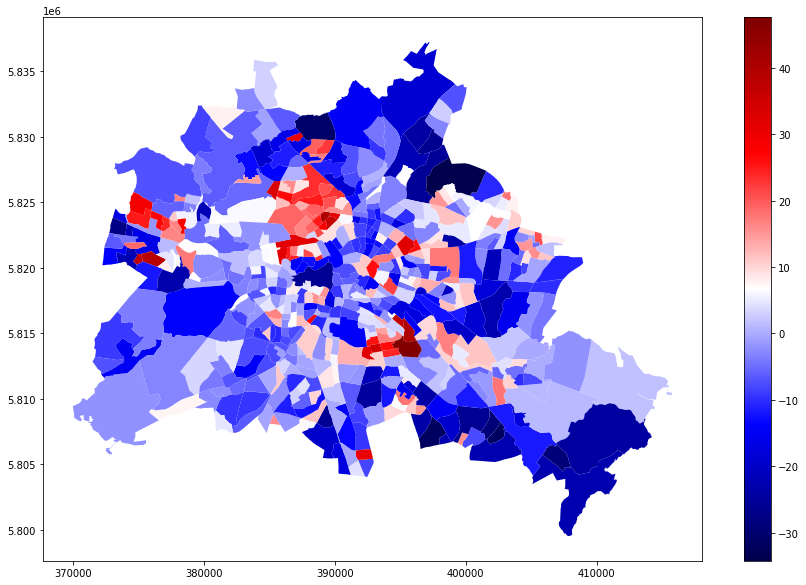

In [44]:
# Adding a resituals column to sample dataframe
selected['residuals_m2'] = m2.u

# plotting residuals - red = underestimation, blue = overestimation
selected.plot('residuals_m2', figsize=(15,10), cmap= 'seismic', legend=True)